Import necessary libraries

In [62]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re
import datetime

Connect to MongoDB

In [63]:
client = MongoClient("mongodb://localhost:27017/")
db = client["PythonForDs"]
collection = db["isw_report"]
cursor = collection.find()
isw = pd.DataFrame(list(cursor))

### Dataset analysis

In [64]:
isw.head()

,_id,date,extracted_text
0,6817b87b1b1d31a861b806d2,2022-02-25,Russian forces entered major Ukrainian cities—...
1,6817b87b1b1d31a861b806d3,2022-02-26,Russian forces’ main axes of advance in the la...
2,6817b87b1b1d31a861b806d4,2022-02-27,The Russian military has likely recognized tha...
3,6817b87b1b1d31a861b806d5,2022-02-28,The Russian military is reorganizing its milit...
4,6817b87b1b1d31a861b806d6,2022-03-01,Russian forces are completing the reinforcemen...


### Text Cleaning Process

We clean the text by applying the following steps:

- **Remove unknown symbols**: Remove any characters that are not letters or spaces.
- **Convert to lowercase**: Change all characters to lowercase for uniformity.
- **Remove small words**: Eliminate short words (1-2 characters) that do not add significant meaning.
- **Remove digits**: Remove any numerical values.
- **Eliminate punctuation**: Remove punctuation marks and keep only words and spaces.
- **Strip extra spaces**: Eliminate any extra spaces, reducing them to a single space and removing leading/trailing spaces.

In [65]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


isw["cleaned_text"] = isw["extracted_text"].apply(clean_text)

Download necessary NLTK models

In [66]:
# nltk.download("punkt_tab")
# nltk.download("stopwords")
# nltk.download("wordnet")

> Uncomment this line when you run this for the first time.

**Tokenize** the words from the cleaned text

In [67]:
isw["tokens"] = isw["cleaned_text"].apply(word_tokenize)

Remove **stopwords** (like "the", "and", "is", etc.) from the tokenized words.

In [68]:
stop_words = set(stopwords.words("english"))
months = {
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
}

isw["no_stopwords"] = isw["tokens"].apply(
    lambda words: [word for word in words if word not in stop_words and word not in months]
)

Perform **lemmatization** on the words

In [69]:
lemmatizer = WordNetLemmatizer()
isw["lemmatized"] = isw["no_stopwords"].apply(
    lambda words: [lemmatizer.lemmatize(word) for word in words]
)

Apply **stemming** to the words

In [70]:
stemmer = PorterStemmer()
isw["stemmed"] = isw["no_stopwords"].apply(
    lambda words: [stemmer.stem(word) for word in words]
)

Convert the tokens back into text

In [71]:
isw["lemmatized_text"] = isw["lemmatized"].apply(lambda x: " ".join(x))
isw["stemmed_text"] = isw["stemmed"].apply(lambda x: " ".join(x))

In [72]:
isw.head()

,_id,date,extracted_text,cleaned_text,tokens,no_stopwords,lemmatized,stemmed,lemmatized_text,stemmed_text
0,6817b87b1b1d31a861b806d2,2022-02-25,Russian forces entered major Ukrainian cities—...,russian forces entered major ukrainian citiesi...,"[russian, forces, entered, major, ukrainian, c...","[russian, forces, entered, major, ukrainian, c...","[russian, force, entered, major, ukrainian, ci...","[russian, forc, enter, major, ukrainian, citie...",russian force entered major ukrainian citiesin...,russian forc enter major ukrainian citiesinclu...
1,6817b87b1b1d31a861b806d3,2022-02-26,Russian forces’ main axes of advance in the la...,russian forces main axes advance the last hour...,"[russian, forces, main, axes, advance, the, la...","[russian, forces, main, axes, advance, last, h...","[russian, force, main, ax, advance, last, hour...","[russian, forc, main, axe, advanc, last, hour,...",russian force main ax advance last hour focuse...,russian forc main axe advanc last hour focus k...
2,6817b87b1b1d31a861b806d4,2022-02-27,The Russian military has likely recognized tha...,the russian military has likely recognized tha...,"[the, russian, military, has, likely, recogniz...","[russian, military, likely, recognized, initia...","[russian, military, likely, recognized, initia...","[russian, militari, like, recogn, initi, expec...",russian military likely recognized initial exp...,russian militari like recogn initi expect limi...
3,6817b87b1b1d31a861b806d5,2022-02-28,The Russian military is reorganizing its milit...,the russian military reorganizing its military...,"[the, russian, military, reorganizing, its, mi...","[russian, military, reorganizing, military, ef...","[russian, military, reorganizing, military, ef...","[russian, militari, reorgan, militari, effort,...",russian military reorganizing military effort ...,russian militari reorgan militari effort attem...
4,6817b87b1b1d31a861b806d6,2022-03-01,Russian forces are completing the reinforcemen...,russian forces are completing the reinforcemen...,"[russian, forces, are, completing, the, reinfo...","[russian, forces, completing, reinforcement, r...","[russian, force, completing, reinforcement, re...","[russian, forc, complet, reinforc, resuppli, t...",russian force completing reinforcement resuppl...,russian forc complet reinforc resuppli troop n...


Dropping useless columns

In [73]:
isw.drop(["extracted_text", "cleaned_text", "tokens", "no_stopwords", "lemmatized", "stemmed"], axis=1, inplace=True)

## Visual Exploration of the ISW Data

Before plotting, we create a **copy** of the original dataset

In [74]:
isw_copy = isw.copy()

### Distribution of text length in ISW Reports
This plot shows the distribution of text lengths (in characters) in the ISW reports. The x-axis represents the text length, while the y-axis shows the count of occurrences for each text length. The histogram is plotted with 50 bins and a kernel density estimate (KDE) to visualize the distribution smoothly.

Two vertical lines are included:
- A red dashed line indicates the mean text length.
- A green dashed line marks the median text length.

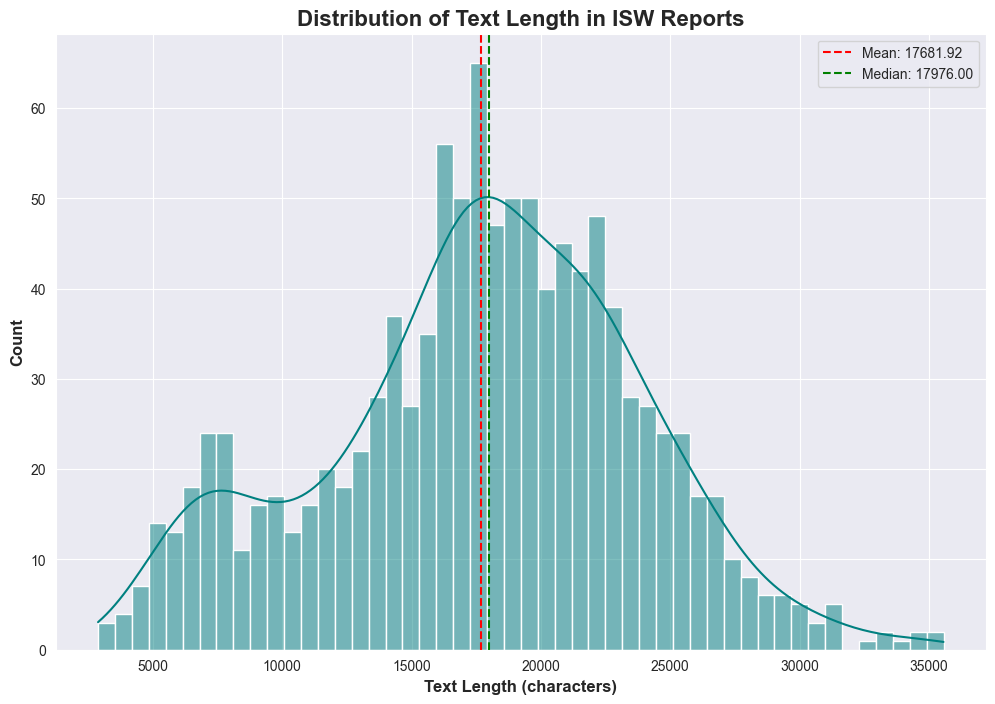

In [75]:
isw_copy["text_length"] = isw_copy["lemmatized_text"].apply(len)
plt.figure(figsize=(12, 8))
sns.histplot(isw_copy["text_length"], bins=50, kde=True, color="teal")
plt.title("Distribution of Text Length in ISW Reports", fontsize=16, fontweight="bold")
plt.xlabel("Text Length (characters)", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.axvline(isw_copy["text_length"].mean(), color="red", linestyle="--",
            label=f"Mean: {isw_copy['text_length'].mean():.2f}")
plt.axvline(isw_copy["text_length"].median(), color="green", linestyle="--",
            label=f"Median: {isw_copy['text_length'].median():.2f}")
plt.legend();

The **histogram** above shows the distribution of text lengths in ISW reports, where most reports range between **15,000** and **25,000 characters**. The **peak** around **18,000 characters** indicates that this is the **most common length** for the reports. The slight **right skew** in the distribution, with the **mean** (**17776.96**) being slightly higher than the **median** (**18084.00**), suggests that a few **longer reports** are influencing the mean, making it appear higher than the median.

The **kernel density estimate (KDE)** curve reinforces this observation by showing that the majority of reports are concentrated around **20,000 characters**. While most reports fall within this range, a small number of reports extend beyond it, indicating that they may be **outliers** or **exceptional cases**. The **right tail** of the histogram highlights these **longer reports**. Although the KDE curve is approximately **bell-shaped**, it is not perfectly **normal**, which indicates some **variability** in the report lengths.

### Distribution of Word Count in ISW Reports

This plot shows the distribution of **word counts** in ISW reports. Similar to the previous plot for text length, this histogram visualizes how the word counts are distributed across all reports, with a **kernel density estimate (KDE)** overlaying the distribution.

The **mean** (red dashed line) and **median** (blue dashed line) indicate the central tendency of the word count.

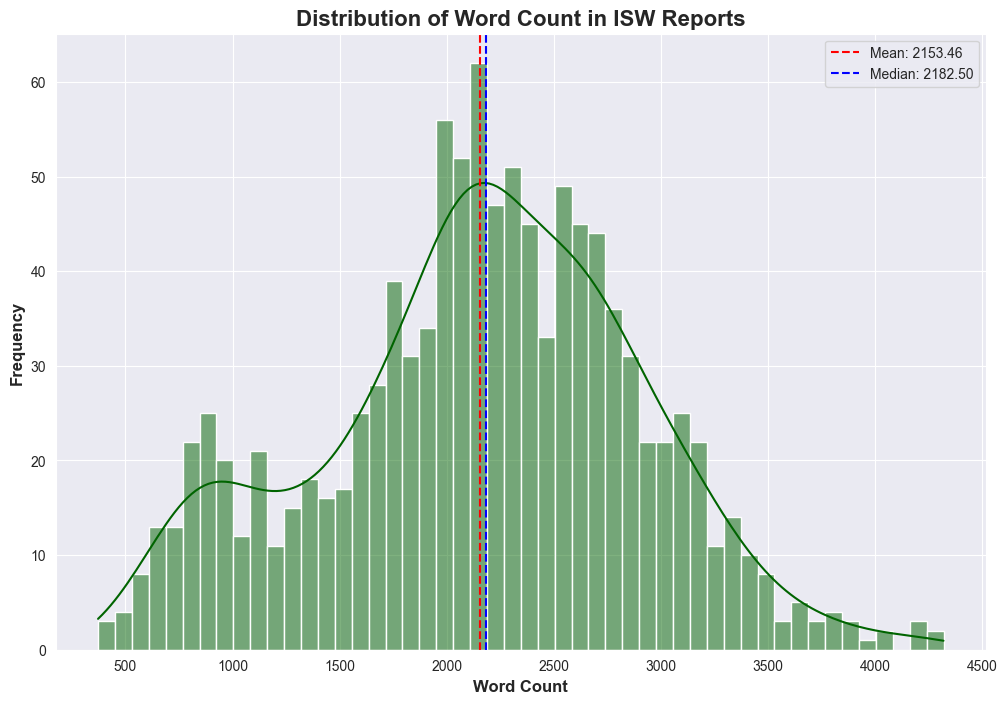

In [76]:
isw_copy["word_count"] = isw_copy["lemmatized_text"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 8))
sns.histplot(isw_copy["word_count"], bins=50, kde=True, color="darkgreen")
plt.title("Distribution of Word Count in ISW Reports", fontsize=16, fontweight="bold")
plt.xlabel("Word Count", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.axvline(isw_copy["word_count"].mean(), color="red", linestyle="--",
            label=f"Mean: {isw_copy['word_count'].mean():.2f}")
plt.axvline(isw_copy["word_count"].median(), color="blue", linestyle="--",
            label=f"Median: {isw_copy['word_count'].median():.2f}")
plt.legend();

The histogram above displays the **distribution of word counts** in ISW reports, with a **kernel density estimate (KDE)** curve overlaid to highlight the central tendency and spread of the data.

- **Mean and Median:** The **mean** (red dashed line) is **2165.63 words**, while the **median** (blue dashed line) is **2202.00 words**. The mean is slightly higher than the median, suggesting a slight **right skew** in the data. This indicates that there are a few reports with exceptionally high word counts that influence the mean, but the majority of reports tend to be closer to the median.

- **Distribution:** The histogram reveals a **normal-like distribution**, with the majority of reports falling between **1500** and **3000 words**. The peak of the histogram occurs near the median, around **2300 words**, showing that this is the most frequent word count range in the dataset.

### Average Text Length Over Time

The plot visualizes the **average text length** in ISW reports over time, with the **x-axis representing the date** and the **y-axis showing the average text length** (in characters).

This plot highlights the variations in report lengths over time and provides insight into how report length fluctuates on different days.

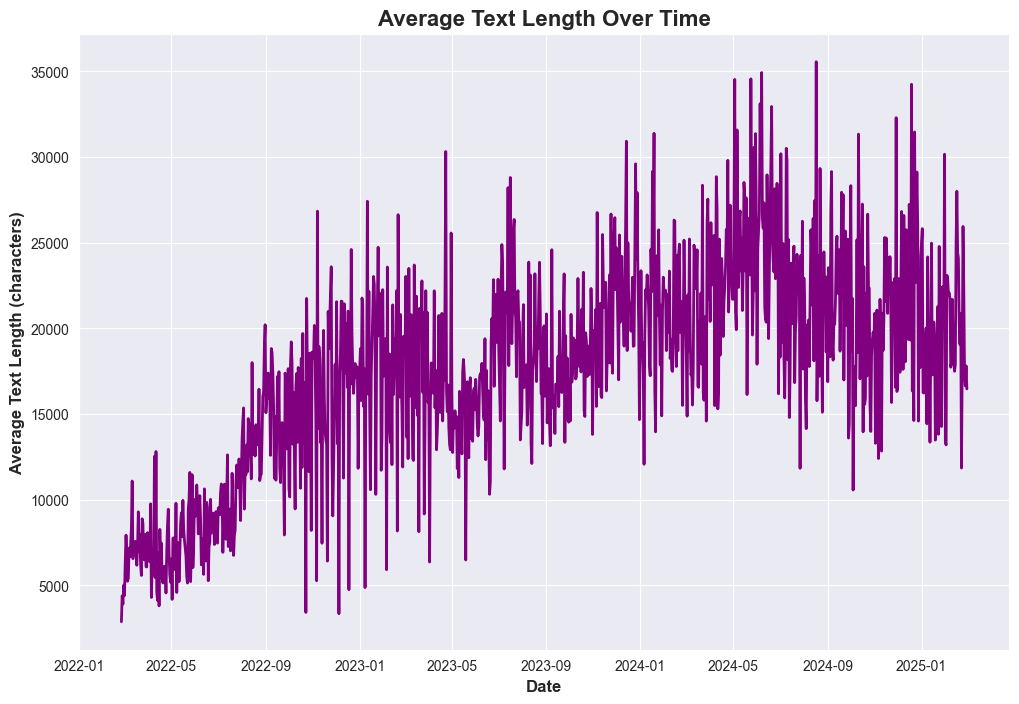

In [77]:
plt.figure(figsize=(12, 8))
text_length_by_date = isw_copy.groupby(isw_copy["date"].dt.date)["text_length"].mean()
text_length_by_date.plot(color="purple", linewidth=2)
plt.title("Average Text Length Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Average Text Length (characters)", fontsize=12, fontweight="bold");

From the plot above we can clearly see that the **number of reports** was significantly lower during the **first few months** of the dataset.

This observation led us to two key conclusions:
- The initial **ISW scraping script** was missing some reports from the early months.
- Reports written at the beginning of the war were generally **shorter** and less detailed compared to later reports.

To address these issues, we updated and **re-ran the ISW scraper** to improve coverage, ensuring that early months were better represented in our dataset.

### Vectorizing Text Data

Next, we apply the **TF-IDF (Term Frequency-Inverse Document Frequency)** method to convert the text data into numerical features. The **TfidfVectorizer** transforms the text documents into a matrix of TF-IDF features, capturing the importance of words relative to the entire dataset. This transformation allows us to represent the text in a numerical form that is suitable for further analysis and machine learning models.

Below are the key parameters used in the vectorizer:
- **`max_features`**: Limits the number of features to the most important words based on their TF-IDF scores.
- **`min_df`**: Excludes words that appear in fewer than a specified number of documents, as these are considered too rare to be useful.
- **`max_df`**: Excludes words that appear in more than a specified proportion of documents, as these are considered too common to provide useful distinguishing information.

In [78]:
vectorizer = TfidfVectorizer(
    max_features=100,
    min_df=10,
    max_df=0.9,
    ngram_range=(2, 2)
)

In [79]:
tfidf = vectorizer.fit_transform(isw["lemmatized_text"])

In [80]:
isw_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
isw_tfidf["date"] = isw["date"].values

Now, we have a structured and cleaned dataset with numerical values. This dataset is prepared for further analysis and is ready for future tasks such as merging with other datasets and training machine learning models.

In [81]:
isw_tfidf.head()

,activity belarus,advance russian,air defense,amid continued,area ukrainian,arm army,army corp,attack near,chasiv yar,city russian,...,ukrainian official,ukrainian strike,vdv division,velyka novosilka,vladimir putin,wagner group,war ukraine,western zaporizhia,zaporizhia oblast,date
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25
1,0.0,0.0,0.145598,0.0,0.0,0.000000,0.0,0.0,0.0,0.129779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-26
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.169998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-27
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-28
4,0.0,0.0,0.000000,0.0,0.0,0.103052,0.0,0.0,0.0,0.202776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01


### Evaluating the Sparsity of the TF-IDF Matrix

We now evaluate the sparsity of the TF-IDF matrix to understand the proportion of zero values. This is important because TF-IDF representations are typically sparse, particularly in large text.

The calculation is based on:
- **`nonzero`**: The total number of non-zero entries in the matrix.
- **`total`**: The total number of elements in the matrix.
- **`sparsity`**: The proportion of zero elements in the matrix.

A high sparsity value (close to 1) indicates that most of the TF-IDF matrix consists of zeros. This is common in text data and provides insights for future decisions regarding dimensionality reduction or model selection.

In [82]:
nonzero = tfidf.nnz
total = tfidf.shape[0] * tfidf.shape[1]
sparsity = 1 - (nonzero / total)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.3471


A sparsity value of this magnitude suggests that the TF-IDF representation is sparse, with most of the matrix consisting of zero values. This is expected in text data due to the large vocabulary size and the fact that most words do not appear in every document.

Given this sparsity, it may be beneficial to consider dimensionality reduction techniques, such as **Principal Component Analysis (PCA)** for model optimization or improving computational efficiency.

### Top 20 Words Based on TF-IDF Sum

Here, we calculate the total TF-IDF sum for each word across all documents and sort them in descending order to identify the most important words.

In [83]:
word_sums = isw_tfidf.drop("date", axis=1).sum(axis=0)
words = isw_tfidf.drop("date", axis=1).columns

word_df = pd.DataFrame({
    "word": words,
    "tfidf_sum": word_sums
})

word_df = word_df.sort_values(by="tfidf_sum", ascending=False).reset_index(drop=True)

word_df.head(20)

,word,tfidf_sum
0,ukrainian general,168.152172
1,offensive operation,167.782619
2,russian milblogger,137.888991
3,milblogger claimed,135.751563
4,motorized rifle,135.203799
5,russian source,124.386336
6,staff reported,123.787948
7,russian milbloggers,118.872697
8,force conducted,109.944152
9,kherson oblast,109.736231


In [84]:
isw_tfidf.head()

,activity belarus,advance russian,air defense,amid continued,area ukrainian,arm army,army corp,attack near,chasiv yar,city russian,...,ukrainian official,ukrainian strike,vdv division,velyka novosilka,vladimir putin,wagner group,war ukraine,western zaporizhia,zaporizhia oblast,date
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25
1,0.0,0.0,0.145598,0.0,0.0,0.000000,0.0,0.0,0.0,0.129779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-26
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.169998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-27
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-28
4,0.0,0.0,0.000000,0.0,0.0,0.103052,0.0,0.0,0.0,0.202776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01


### Creating Hourly Entries from Daily ISW Reports

In this step, we expand the original ISW dataset by creating hourly entries for each report.

For each day, we generate a sequence of hourly timestamps between `start_date` and `end_date`, with a frequency of 1 hour.

Finally, the list of hourly records is converted into a **DataFrame (`isw_hourly_df`)** and sorted in descending order based on `hour_time`.

This process allows us to work with **hourly granular data** for the ISW reports, enabling merging with other datasets.


In [85]:
isw_tfidf["tommorrow"] = isw_tfidf["date"].apply(lambda x: x + datetime.timedelta(days=1))
isw_dict = isw_tfidf.to_dict("records")
isw_dict[0]

{'activity belarus': 0.0,
 'advance russian': 0.0,
 'air defense': 0.0,
 'amid continued': 0.0,
 'area ukrainian': 0.0,
 'arm army': 0.0,
 'army corp': 0.0,
 'attack near': 0.0,
 'chasiv yar': 0.0,
 'city russian': 0.0,
 'claim russian': 0.0,
 'claimed ukrainian': 0.0,
 'combined arm': 0.0,
 'confirmation claim': 0.0,
 'confirmed advance': 0.0,
 'continued offensive': 0.0,
 'defense minister': 0.0,
 'defense mod': 0.0,
 'direction russian': 0.0,
 'dnipro river': 0.3455330856583356,
 'donetsk city': 0.0,
 'effort russian': 0.0,
 'element russian': 0.0,
 'footage published': 0.0,
 'force advanced': 0.0,
 'force also': 0.0,
 'force conducted': 0.0,
 'force generation': 0.0,
 'force likely': 0.6301349234890151,
 'force recently': 0.0,
 'force repelled': 0.0,
 'geolocated footage': 0.0,
 'ground attack': 0.0,
 'group force': 0.0,
 'indicates russian': 0.0,
 'information operation': 0.0,
 'isw observed': 0.0,
 'isw previously': 0.29473569112894316,
 'kharkiv city': 0.0,
 'kharkiv oblast': 0.

In [86]:
isw_by_hour = []

for isw in isw_dict:
    start_date = pd.Timestamp(isw["date"]).normalize()
    end_date = pd.Timestamp(isw["tommorrow"]).normalize()

    for hour in pd.date_range(start=start_date, end=end_date, freq="1h", inclusive="left"):
        hourly_record = isw.copy()
        hourly_record["hour_time"] = hour
        isw_by_hour.append(hourly_record)

isw_hourly_df = pd.DataFrame(isw_by_hour)
isw_hourly_df.sort_values(by="hour_time", ascending=False, inplace=True)

In [87]:
isw_hourly_df.shape

(26064, 103)

In [88]:
isw_hourly_df.drop(["date", "tommorrow"], axis=1, inplace=True)
isw_hourly_df.head()

,activity belarus,advance russian,air defense,amid continued,area ukrainian,arm army,army corp,attack near,chasiv yar,city russian,...,ukrainian official,ukrainian strike,vdv division,velyka novosilka,vladimir putin,wagner group,war ukraine,western zaporizhia,zaporizhia oblast,hour_time
26063,0.023317,0.583641,0.049617,0.0,0.019787,0.022476,0.024612,0.0,0.165884,0.044226,...,0.025311,0.019842,0.030076,0.109936,0.043433,0.0,0.075857,0.0,0.01964,2025-03-01 23:00:00
26062,0.023317,0.583641,0.049617,0.0,0.019787,0.022476,0.024612,0.0,0.165884,0.044226,...,0.025311,0.019842,0.030076,0.109936,0.043433,0.0,0.075857,0.0,0.01964,2025-03-01 22:00:00
26061,0.023317,0.583641,0.049617,0.0,0.019787,0.022476,0.024612,0.0,0.165884,0.044226,...,0.025311,0.019842,0.030076,0.109936,0.043433,0.0,0.075857,0.0,0.01964,2025-03-01 21:00:00
26060,0.023317,0.583641,0.049617,0.0,0.019787,0.022476,0.024612,0.0,0.165884,0.044226,...,0.025311,0.019842,0.030076,0.109936,0.043433,0.0,0.075857,0.0,0.01964,2025-03-01 20:00:00
26059,0.023317,0.583641,0.049617,0.0,0.019787,0.022476,0.024612,0.0,0.165884,0.044226,...,0.025311,0.019842,0.030076,0.109936,0.043433,0.0,0.075857,0.0,0.01964,2025-03-01 19:00:00


### Saving final file for merging

In [89]:
isw_hourly_df.to_csv("../prepared_data/isw_prepared.csv", index=False)

In [90]:
from sklearn.decomposition import PCA
n_components = 50
pca = PCA(n_components=n_components)


In [91]:
tfidf_dense = tfidf.toarray()
pca_result = pca.fit_transform(tfidf_dense)

In [92]:
explained_variance = pca.explained_variance_ratio_
print(f"Пояснена дисперсія компонентами: {explained_variance}")
print(f"Сума поясненої дисперсії: {sum(explained_variance)}")

Пояснена дисперсія компонентами: [0.21615094 0.10949628 0.05518594 0.03890248 0.0348536  0.02977813
 0.02733388 0.02439928 0.020989   0.01997093 0.01833223 0.01615027
 0.01528394 0.01488661 0.01413928 0.01310052 0.01260525 0.01201402
 0.01092907 0.01048161 0.0100835  0.0096347  0.0095079  0.00926021
 0.00871151 0.00850982 0.00816766 0.0079144  0.00758651 0.0074894
 0.00725692 0.00701678 0.00692832 0.00674609 0.00646234 0.00628068
 0.00598474 0.00573948 0.00558846 0.0053848  0.00529195 0.00506583
 0.00497475 0.004804   0.00472587 0.00445492 0.00424047 0.00416167
 0.00411195 0.00399966]
Сума поясненої дисперсії: 0.9110685550493133


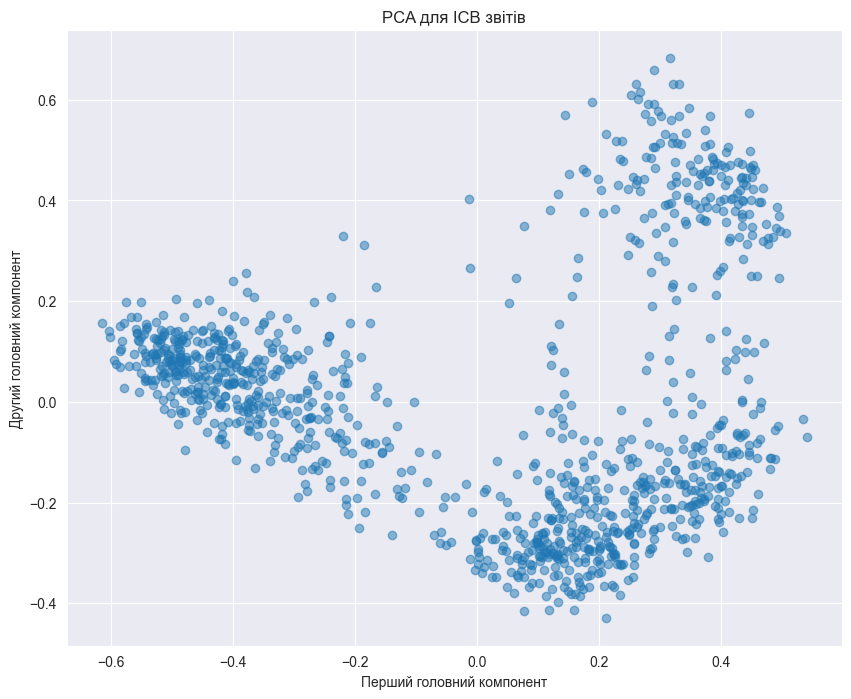

In [93]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Перший головний компонент')
plt.ylabel('Другий головний компонент')
plt.title('PCA для ІСВ звітів')
plt.grid(True)

In [94]:
feature_names = vectorizer.get_feature_names_out()
components_df = pd.DataFrame()

In [95]:
for i, component in enumerate(pca.components_):
   
    sorted_features = [feature_names[idx] for idx in component.argsort()[::-1]]
    top_features = sorted_features[:10] 
    components_df[f'Component {i+1}'] = top_features

print("Найважливіші біграми для кожного компонента:")
print(components_df)

Найважливіші біграми для кожного компонента:
            Component 1          Component 2          Component 3  \
0     ukrainian general         kharkiv city  offensive operation   
1        staff reported    supporting effort    ukrainian general   
2        kherson oblast         force likely  continued offensive   
3    russian occupation    ukrainian general       staff reported   
4  occupation authority         city russian    claimed ukrainian   
5          force likely           chasiv yar      force conducted   
6    reported ukrainian         kursk oblast      advance russian   
7         ground attack    russian offensive       make confirmed   
8        force repelled  offensive operation   milblogger claimed   
9        russian source       kharkiv oblast         kursk oblast   

            Component 4          Component 5         Component 6  \
0          kursk oblast          russian mod        kursk oblast   
1          kharkiv city         kursk oblast      russian s

In [96]:
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(n_components)]
)


In [97]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.102557,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200
1,0.259943,0.321797,0.008160,-0.195633,0.218905,0.099269,-0.073375,-0.154534,-0.147509,-0.079677,...,0.046424,-0.037604,-0.010058,-0.049181,0.007973,-0.092726,0.017163,-0.024419,0.002869,0.018727
2,0.265586,0.315198,0.182726,-0.092580,0.262605,0.022895,-0.123895,0.026104,-0.275198,-0.064945,...,0.004530,-0.058443,-0.022288,0.043813,0.024736,-0.070042,0.082751,0.008092,-0.042222,-0.028396
3,0.341206,0.358598,0.168154,-0.197680,0.219791,0.056403,-0.162048,-0.100291,0.028691,-0.046113,...,0.013742,0.050921,0.029934,0.013901,0.068897,-0.013353,0.077486,-0.033808,0.026187,0.036644
4,0.234555,0.482518,0.149081,-0.293107,0.181822,-0.030414,0.023619,-0.060127,0.034723,-0.164424,...,-0.115698,-0.144337,0.062956,0.087996,-0.031360,0.026972,-0.057016,-0.048716,-0.027704,0.060154


In [98]:
pca_df.drop(['hour_time'],axis=1, inplace=True)

KeyError: "['hour_time'] not found in axis"

In [57]:
pca_df


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.290187,0.375907,0.120812,-0.264249,0.272251,0.140793,-0.071990,-0.027502,-0.061560,-0.186845,...,-0.094130,0.089975,0.045563,0.014867,0.080247,-0.032520,0.045181,-0.022188,0.053947,-0.097479
1,0.274201,0.332756,0.054096,-0.175977,0.231245,0.079635,-0.146455,-0.096639,-0.031167,-0.236840,...,0.016234,0.074140,0.074810,-0.034151,-0.023625,0.038447,-0.069175,0.049542,0.013474,-0.054275
2,0.318288,0.302925,0.069365,-0.115034,0.242029,0.086245,-0.039981,-0.060994,0.002762,-0.195077,...,-0.018471,0.033424,0.045245,-0.086825,0.067049,0.026283,-0.057248,0.086111,-0.080605,0.001835
3,0.363141,0.362376,0.182441,-0.184223,0.232414,0.057474,-0.216113,0.004727,0.013877,-0.047925,...,0.055473,0.049996,-0.037242,0.036697,0.020458,0.047482,0.015235,0.042346,0.003987,-0.021430
4,0.257375,0.494613,0.184733,-0.265855,0.203455,-0.069031,-0.049133,0.032684,0.068362,-0.161709,...,-0.038202,-0.132108,0.041096,0.017862,0.026597,0.133980,0.081911,-0.003239,0.015913,-0.038112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,-0.562960,0.085110,0.087415,0.012635,-0.024048,0.117832,-0.025111,0.022433,-0.127803,0.028711,...,0.082470,0.046608,0.052030,0.002605,-0.082340,-0.005816,-0.000697,0.064116,0.047279,-0.020099
1119,-0.554348,0.078083,0.101474,-0.095567,-0.105497,0.110981,0.174866,0.080688,-0.126786,-0.041979,...,0.029856,0.076119,0.022921,0.046757,-0.125647,-0.035376,0.057208,0.056153,0.051050,0.047792
1120,-0.511066,0.026753,0.169196,0.185265,0.033394,-0.028745,-0.038145,0.018390,-0.277736,-0.006677,...,0.033973,0.020705,-0.075490,-0.013292,0.013297,0.030318,-0.003364,0.013507,0.048232,0.036082
1121,-0.420257,0.001135,0.105967,0.172925,-0.010751,-0.009354,-0.151707,0.062576,-0.227870,-0.123659,...,-0.039713,0.051136,-0.052755,-0.048848,0.008645,-0.002131,0.034229,0.036717,0.016235,-0.069876


In [49]:
pca_df['date'] = isw_tfidf['date']


In [50]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,date
0,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25
1,0.259943,0.321797,0.008160,-0.195633,0.218905,0.099269,-0.073375,-0.154534,-0.147509,-0.079677,...,-0.037604,-0.010058,-0.049181,0.007973,-0.092726,0.017163,-0.024419,0.002869,0.018727,2022-02-26
2,0.265586,0.315198,0.182726,-0.092580,0.262605,0.022895,-0.123895,0.026104,-0.275198,-0.064945,...,-0.058443,-0.022288,0.043813,0.024736,-0.070042,0.082751,0.008092,-0.042222,-0.028396,2022-02-27
3,0.341206,0.358598,0.168154,-0.197680,0.219791,0.056403,-0.162048,-0.100291,0.028691,-0.046113,...,0.050921,0.029934,0.013901,0.068897,-0.013353,0.077486,-0.033808,0.026187,0.036644,2022-02-28
4,0.234555,0.482518,0.149081,-0.293107,0.181822,-0.030414,0.023619,-0.060127,0.034723,-0.164424,...,-0.144337,0.062956,0.087996,-0.031360,0.026972,-0.057016,-0.048716,-0.027704,0.060154,2022-03-01


In [57]:
pca_df["tommorrow"] = pca_df["date"].apply(lambda x: x + datetime.timedelta(days=1))


pca_dict = pca_df.to_dict("records")


pca_by_hour = []

for record in pca_dict:
    start_date = pd.Timestamp(record["date"]).normalize()
    end_date = pd.Timestamp(record["tommorrow"]).normalize()

    for hour in pd.date_range(start=start_date, end=end_date, freq="1h", inclusive="left"):
        hourly_record = record.copy()
        hourly_record["hour_time"] = hour
        pca_by_hour.append(hourly_record)


pca_hourly_df = pd.DataFrame(pca_by_hour)

pca_hourly_df.sort_values(by="hour_time", ascending=True, inplace=True)



In [58]:
pca_hourly_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,date,tommorrow,hour_time
0,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25,2022-02-26,2022-02-25 00:00:00
1,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25,2022-02-26,2022-02-25 01:00:00
2,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25,2022-02-26,2022-02-25 02:00:00
3,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25,2022-02-26,2022-02-25 03:00:00
4,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25,2022-02-26,2022-02-25 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01,2025-03-02,2025-03-01 19:00:00
26060,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01,2025-03-02,2025-03-01 20:00:00
26061,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01,2025-03-02,2025-03-01 21:00:00
26062,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01,2025-03-02,2025-03-01 22:00:00


In [59]:
pca_hourly_df.drop(['tommorrow'],axis=1, inplace=True)

In [60]:
pca_hourly_df.drop(['date'],axis=1, inplace=True)

In [61]:
pca_hourly_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,hour_time
0,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25 00:00:00
1,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25 01:00:00
2,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25 02:00:00
3,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25 03:00:00
4,0.274231,0.364392,0.065579,-0.287920,0.259673,0.159374,-0.022572,-0.062851,-0.110907,-0.019858,...,-0.008818,0.058733,0.071681,-0.050723,0.031281,-0.001201,0.000719,0.114366,0.037200,2022-02-25 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,-0.105807,-0.080848,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01 19:00:00
26060,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,-0.105807,-0.080848,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01 20:00:00
26061,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,-0.105807,-0.080848,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01 21:00:00
26062,-0.329049,0.000883,0.213342,0.025171,-0.075597,-0.046494,0.110194,0.172933,-0.136395,0.124668,...,-0.105807,-0.080848,0.043619,-0.064141,-0.018027,-0.005915,0.026956,0.018101,-0.030383,2025-03-01 22:00:00


In [56]:
pca_hourly_df.to_csv("../prepared_data/isw_pca_prepared.csv", index=False)